# Imports

In [2]:
from visual_kinematics.RobotSerial import *
import numpy as np
import sympy as sp
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Visual kinematics for checking

ERROR:root:Pose cannot be reached!


Axis values (radians): [ 3.41189602e-02  1.75684508e+03 -3.51734384e+03  1.76046543e+03]


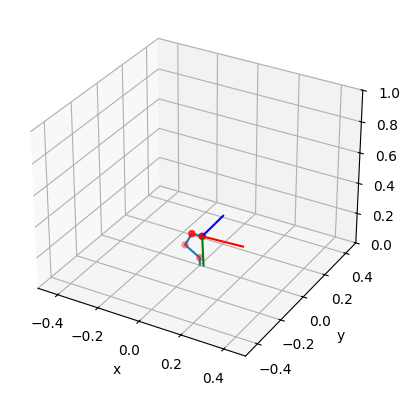

In [3]:
dh_params = np.array([[0.05, 0, -0.5*pi, 0],
                      [0, 0.093, 0, 0],
                      [0, 0.093, 0, 0],
                      [0, 0.05, 0, 0],
                      ])
robot = RobotSerial(dh_params)
xyz = np.array([[0], [0.05], [0.236]])
abc = np.array([0, 0, 0])
end = Frame.from_euler_3(abc, xyz)
robot.inverse(end)
robot.forward(robot.axis_values)
print("Axis values (radians):", robot.axis_values)
robot.show()

# Visualization

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_robot_arm_3d(joint_positions, show_axes=True):
    """
    Visualize a 3D robot arm using joint positions.
    
    Parameters:
        joint_positions: list of (x, y, z) tuples/lists
            Example: [(0,0,0), (1,0,0), (1,1,0), (1,1,1)]
        show_axes: bool -> Whether to show coordinate axes.
    """
    # Ensure positions are tuples
    points = [tuple(p) for p in joint_positions]
    xs, ys, zs = zip(*points)
    
    # Create 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot links
    ax.plot(xs, ys, zs, '-o', color='royalblue', linewidth=3, markersize=8)
    
    # Mark base and end effector
    ax.scatter(xs[0], ys[0], zs[0], color='green', s=80, label='Base')
    ax.scatter(xs[-1], ys[-1], zs[-1], color='red', s=80, label='End Effector')
    
    ax.legend()
    ax.set_title("3D Robot Arm Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Equal aspect ratio
    max_range = max(max(xs)-min(xs), max(ys)-min(ys), max(zs)-min(zs)) / 2.0
    mid_x = (max(xs) + min(xs)) / 2.0
    mid_y = (max(ys) + min(ys)) / 2.0
    mid_z = (max(zs) + min(zs)) / 2.0
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    if not show_axes:
        ax.set_axis_off()

    plt.show()


# Problem 1 (Forward kinematics)

Test output for T04 at zero angles:
[236.   0.  50.]


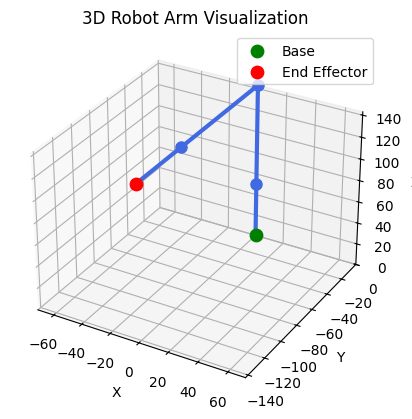

In [53]:
dh_matrix = np.array([[0, 50, 0, 0.5*pi],
                      [0, 0, 93, 0],
                      [0, 0, 93, 0],
                      [0, 0, 50, 0],
                      ])

def make_DH_matrix(theta, d, a, alpha):
        """Create individual DH transformation matrix."""
        T = np.array([[math.cos(theta), -math.sin(theta)*math.cos(alpha),  math.sin(theta)*math.sin(alpha), a*math.cos(theta)],
                      [math.sin(theta),  math.cos(theta)*math.cos(alpha), -math.cos(theta)*math.sin(alpha), a*math.sin(theta)],
                      [0,                math.sin(alpha),                  math.cos(alpha),                 d],
                      [0,                0,                                0,                               1]])
        return T

T45 = np.array([
    [1, 0, 0, -15],
    [0, 1, 0,  45],
    [0, 0, 1,  0.0],
    [0, 0, 0,  1],
])

def forward_kinematics(joint_angles):
    """Compute the forward kinematics for the robot given joint angles."""
    theta1, theta2, theta3, theta4 = [math.radians(a) for a in joint_angles]

    T01 = make_DH_matrix(theta1, dh_matrix[0][1], dh_matrix[0][2], dh_matrix[0][3])
    T12 = make_DH_matrix(theta2, dh_matrix[1][1], dh_matrix[1][2], dh_matrix[1][3])
    T23 = make_DH_matrix(theta3, dh_matrix[2][1], dh_matrix[2][2], dh_matrix[2][3])
    T34 = make_DH_matrix(theta4, dh_matrix[3][1], dh_matrix[3][2], dh_matrix[3][3])

    T04 = T01 @ T12 @ T23 @ T34
    return T04

def forward_kinematics_with_all_angles(joint_angles):
    """Compute the forward kinematics for the robot given joint angles and return all intermediate transforms."""
    theta1, theta2, theta3, theta4 = [math.radians(a) for a in joint_angles]

    T01 = make_DH_matrix(theta1, dh_matrix[0][1], dh_matrix[0][2], dh_matrix[0][3])
    T12 = make_DH_matrix(theta2, dh_matrix[1][1], dh_matrix[1][2], dh_matrix[1][3])
    T23 = make_DH_matrix(theta3, dh_matrix[2][1], dh_matrix[2][2], dh_matrix[2][3])
    T34 = make_DH_matrix(theta4, dh_matrix[3][1], dh_matrix[3][2], dh_matrix[3][3])

    T02 = T01 @ T12
    T03 = T02 @ T23
    T04 = T03 @ T34
    return T01, T02, T03, T04

# test output
print("Test output for T04 at zero angles:")
print(forward_kinematics_with_all_angles([0, 0, 0, 0])[-1][:3, 3])
# Visualize robot at given joint angles
joint_angles = [90, 90, 90, 0]
T01, T02, T03, T04 = forward_kinematics_with_all_angles(joint_angles)
positions = [joint[:3, 3] for joint in [np.eye(4), T01, T02, T03, T04]]
plot_robot_arm_3d(positions)

# Problem 2 (Inverz kinematics)

Joint angles for target position [0, 236, 50] : [90.0, 0.0, -0.0, 0.0]
End-effector position from forward kinematics: [1.44508322e-14 2.36000000e+02 5.00000000e+01]


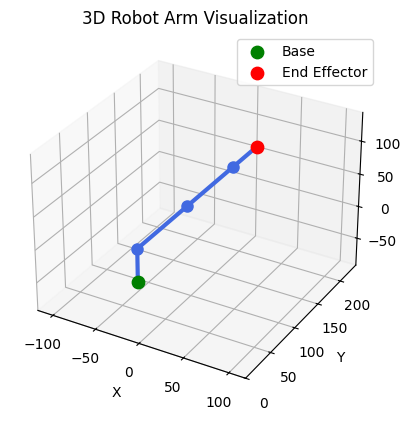

In [6]:
def inverse(x, y, z, theta=0):
        """Compute inverse kinematics for given target_position [x,y,z]. Returns joint angles (deg)."""
        d1 = dh_matrix[0][1]
        a2 = dh_matrix[1][2]
        a3 = dh_matrix[2][2]
        a4 = dh_matrix[3][2]

        # Compute theta1
        theta1 = math.atan2(y, x)

        # Coordinates in the plane of the arm
        r = math.hypot(x, y)
        s = z - d1
        wx = r - a4 * math.cos(theta)
        wy = s - a4 * math.sin(theta)

        # Compute theta3
        c3 = (wx**2 + wy**2 - a2**2 - a3**2) / (2 * a2 * a3)
        if abs(c3) > 1:
            raise ValueError("Target position is unreachable.")
        s3 = -math.sqrt(1 - c3**2)
        theta3 = math.atan2(s3, c3)

        # Compute theta2
        s2 = ((a2 + a3 * c3) * wy - a3 * s3 * wx) / (a2**2 + a3**2 + 2 * a2 * a3 * c3)
        c2 = ((a2 + a3 * c3) * wx + a3 * s3 * wy) / (a2**2 + a3**2 + 2 * a2 * a3 * c3)
        theta2 = math.atan2(s2, c2)

        # Compute theta4
        theta4 = theta - theta2 - theta3

        # Return joint angles in degrees
        joint_angles = [math.degrees(ang) for ang in [theta1, theta2, theta3, theta4]]
        return joint_angles

# Test inverse kinematics
target_position = [0, 236, 50]
joint_angles = inverse(*target_position)
print("Joint angles for target position", target_position, ":", joint_angles)
# Verify with forward kinematics
T01, T02, T03, T04 = forward_kinematics_with_all_angles(joint_angles)
print("End-effector position from forward kinematics:", T04[:3, 3])
plot_robot_arm_3d([np.eye(4)[:3, 3], T01[:3, 3], T02[:3, 3], T03[:3, 3], T04[:3, 3]])

# Task 3 (Tracking circle)

Circle points:
[150.  32. 120.]
[150.          31.53970913 125.40802625]
[150.          30.17207825 130.66047343]
[150.          27.93645162 135.6062382 ]
[150.          24.89714414 140.10303991]
[150.          21.14159115 144.02151377]
[150.          16.77783307 147.24893241]
[150.          11.93140729 149.69244887]
[150.           6.74173664 151.28176765]
[150.           1.3581185  151.97116692]
[150.          -4.06457023 151.74081393]
[150.          -9.37032868 150.59733551]
[150.         -14.40651983 148.57362746]
[150.         -19.02826164 145.72790817]
[150.         -23.10259501 142.14204381]
[150.         -26.51230878 137.91919316]
[150.         -29.15931169 133.18083994]
[150.         -30.9674543  128.06329796]
[150.         -31.88471963 122.71378958]
[150.         -31.88471963 117.28621042]
[150.         -30.9674543  111.93670204]
[150.         -29.15931169 106.81916006]
[150.         -26.51230878 102.08080684]
[150.         -23.10259501  97.85795619]
[150.         -19.0282616

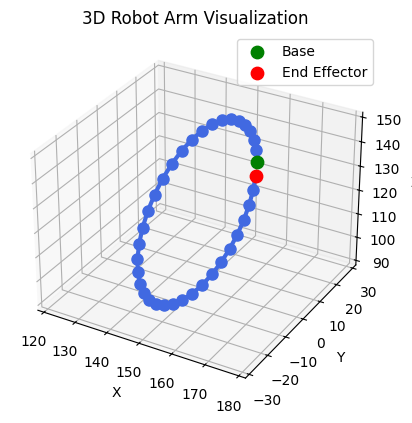

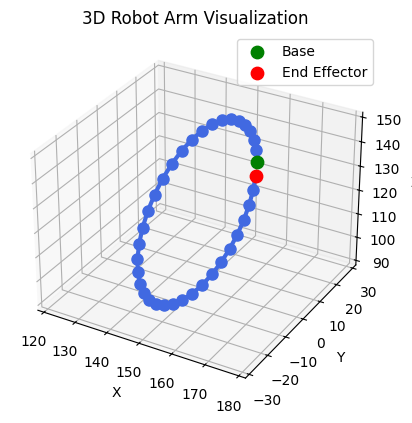

In [15]:
def get_circle_points(center, radius, num_points=37):
    """Generate points on a circle in the XY plane at a given Z height."""
    cx, cy, cz = center
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        p = center + radius * np.array([0, math.cos(angle), math.sin(angle)])
        points.append(p)
    return points

# Define circle parameters
circle_center = (150, 0, 120)
circle_radius = 32
circle_points = get_circle_points(circle_center, circle_radius)
print("Circle points:")
for p in circle_points:
    print(p)
plot_robot_arm_3d(circle_points)
end_effector_positions = []
for i, point in enumerate(circle_points):
    # print("Target point on circle(", i, "):", point)
    joint_angles = inverse(*point)
    # print("  Joint angles:", joint_angles)
    T01, T02, T03, T04 = forward_kinematics_with_all_angles(joint_angles)
    # print("  FK end-effector position:", T04[:3, 3])
    end_effector_positions.append(T04[:3, 3])

plot_robot_arm_3d(end_effector_positions)

# Task 4 (Jacobian matrix)

In [8]:
def jacobian(joint_angles):
    """Compute the Jacobian matrix for the robot at given joint angles."""
    T01, T02, T03, T04 = forward_kinematics_with_all_angles(joint_angles)
    T05 = T04 @ T45
    J = np.zeros((6, 4))
    for i in range(4):
        on = T04[:3, 3]
        # Get zi and oi for joint i
        zi = np.array([0, 0, 1]) if i == 0 else T01[:3, 2] if i == 1 else T02[:3, 2] if i == 2 else T03[:3, 2]
        oi = np.array([0, 0, 0]) if i == 0 else T01[:3, 3] if i == 1 else T02[:3, 3] if i == 2 else T03[:3, 3]

        Jil = np.cross(zi, on - oi) # Linear velocity part
        Jiw = zi                    # Angular velocity part
        J[0:3, i] = Jil
        J[3:6, i] = Jiw
    return J

# Get the points along the circle at angles 0, pi/2, pi, 3pi/2
for angle in [0, math.pi/2, math.pi, 3*math.pi/2]:
    point = circle_center + circle_radius * np.array([0, math.cos(angle), math.sin(angle)])
    joint_angles = inverse(*point)
    print(f"Computing Jacobian at angle {angle} (point {point}) with joint angles {joint_angles}")
    J = jacobian(joint_angles)
    print(f"Jacobian at angle {angle} (point {point}):\n", J)
    print("----------------------------------")

Computing Jacobian at angle 0 (point [150.  32. 120.]) with joint angles [12.042575142884983, 81.94284270506607, -95.6783723581589, 13.735529653092824]
Jacobian at angle 0 (point [150.  32. 120.]):
 [[-3.20000000e+01 -6.84594985e+01  2.15960112e+01 -6.38771092e-16]
 [ 1.50000000e+02 -1.46046930e+01  4.60714905e+00  2.99423949e-15]
 [ 0.00000000e+00  1.53375357e+02  1.40340392e+02  5.00000000e+01]
 [ 0.00000000e+00  2.08638472e-01  2.08638472e-01  2.08638472e-01]
 [ 0.00000000e+00 -9.77992836e-01 -9.77992836e-01 -9.77992836e-01]
 [ 1.00000000e+00  6.12323400e-17  6.12323400e-17  6.12323400e-17]]
----------------------------------
Computing Jacobian at angle 1.5707963267948966 (point [1.50000000e+02 1.95943488e-15 1.52000000e+02]) with joint angles [7.484489918437201e-16, 85.39524897629519, -79.65596513287453, -5.739283843420675]
Jacobian at angle 1.5707963267948966 (point [1.50000000e+02 1.95943488e-15 1.52000000e+02]):
 [[-8.20513355e-15 -1.02000000e+02 -9.30018309e+00 -3.99935942e-32]

# Task 5 (Joint velocities)

In [9]:
angle = math.pi/2
point = circle_center + circle_radius * np.array([0, math.cos(angle), math.sin(angle)])
joint_angles = inverse(*point)
print(f"Computing Jacobian at angle {angle} (point {point}) with joint angles {joint_angles}")
J = jacobian(joint_angles)
print(f"Jacobian at angle {angle} (point {point}):\n", J)

Ji = np.linalg.pinv(J)
print("Pseudo-inverse of Jacobian:\n", Ji)

pszi = np.array([0, -3, 0, 0, 0, 0])
q_dot = Ji @ pszi
print("Joint velocities for end-effector velocity", pszi, ":\n", q_dot)


Computing Jacobian at angle 1.5707963267948966 (point [1.50000000e+02 1.95943488e-15 1.52000000e+02]) with joint angles [7.484489918437201e-16, 85.39524897629519, -79.65596513287453, -5.739283843420675]
Jacobian at angle 1.5707963267948966 (point [1.50000000e+02 1.95943488e-15 1.52000000e+02]):
 [[-8.20513355e-15 -1.02000000e+02 -9.30018309e+00 -3.99935942e-32]
 [ 1.50000000e+02  7.85243528e-15  8.60619155e-15  3.06161700e-15]
 [ 0.00000000e+00  1.50000000e+02  1.42533813e+02  5.00000000e+01]
 [ 0.00000000e+00  1.30628992e-17  1.30628992e-17  1.30628992e-17]
 [ 0.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.00000000e+00  6.12323400e-17  6.12323400e-17  6.12323400e-17]]
Pseudo-inverse of Jacobian:
 [[ 0.00000000e+00  6.66637038e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.44424692e-05]
 [-1.08755442e-02  1.65493551e-19 -1.09305505e-03 -4.64937324e-22
  -5.46527525e-02  5.11315054e-18]
 [ 1.17530487e-02  4.04991557e-19  1.19881097e-02  1.42282674e-21
   

# Task 6 (Trajectory planning)



Condition number at point 0 : 345.8235594603193
Condition number at point 1 : 350.15332109449764
Joint velocities at point 0: [-6.80127524e-05 -5.13284425e-04  5.87344809e-04 -7.40603840e-05]
Joint velocities at point 1: [-6.71178932e-05 -5.18208027e-04  5.85160434e-04 -6.69524078e-05]
Quintic coefficients for joint 0 from point 0 to 1: [ 1.20425751e+01 -6.80127524e-05  0.00000000e+00 -2.10167952e-01
  1.57626076e-01 -3.15252263e-02]
Quintic coefficients for joint 1 from point 0 to 1: [ 8.19428427e+01 -5.13284425e-04  0.00000000e+00  9.47737854e-01
 -7.10804006e-01  1.42160863e-01]
Quintic coefficients for joint 2 from point 0 to 1: [-9.56783724e+01  5.87344809e-04  0.00000000e+00  3.18244221e+00
 -2.38683193e+00  4.77366413e-01]
Quintic coefficients for joint 3 from point 0 to 1: [ 1.37355297e+01 -7.40603840e-05  0.00000000e+00 -4.13018006e+00
  3.09763593e+00 -6.19527276e-01]


Condition number at point 1 : 350.15332109449764
Condition number at point 2 : 354.70869855666086
Joint v

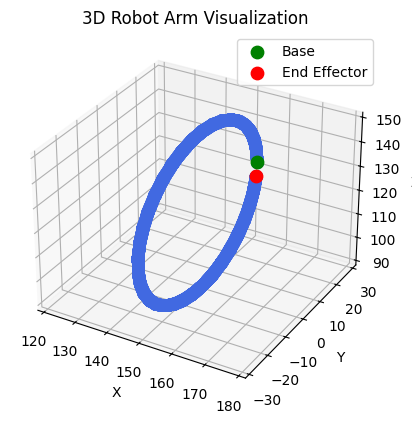

In [58]:
def compute_quintic_coeffs(theta0, thetaf, vel0, velf, acc0, accf, T):
    """
    Computes quintic polynomial coefficients for trajectory:
    theta(t) = a0 + a1*t + a2*t^2 + a3*t^3 + a4*t^4 + a5*t^5
    """
    # Boundary conditions vector
    b = np.array([theta0, vel0, acc0, thetaf, velf, accf])

    # Time matrix
    A = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0],
        [1, T, T**2, T**3, T**4, T**5],
        [0, 1, 2*T, 3*T**2, 4*T**3, 5*T**4],
        [0, 0, 2, 6*T, 12*T**2, 20*T**3]
    ])

    # Solve for coefficients
    coeffs = np.linalg.solve(A, b)
    return coeffs

def evaluate_quintic(coeffs, t):
    """
    Evaluates position, velocity, acceleration at time t
    """
    a0, a1, a2, a3, a4, a5 = coeffs
    theta = a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5
    theta_dot = a1 + 2*a2*t + 3*a3*t**2 + 4*a4*t**3 + 5*a5*t**4
    theta_ddot = 2*a2 + 6*a3*t + 12*a4*t**2 + 20*a5*t**3
    return theta, theta_dot, theta_ddot


# joint_waypoints = [0, 9, 18, 27, 36]
joint_waypoints = range(len(circle_points))
end_effector_positions = []

for i in range(len(joint_waypoints) - 1):
    print()
    print("================================")
    print()
    # Points
    p0 = joint_waypoints[i]
    p1 = joint_waypoints[i+1]
    # Angles
    q0 = inverse(*circle_points[p0])
    q1 = inverse(*circle_points[p1])
    # Jacobians
    J0 = jacobian(q0)
    sigma = np.linalg.svd(J0, compute_uv=False)
    kappa = sigma[0] / sigma[-1]
    print("Condition number at point", p0, ":", kappa)

    J1 = jacobian(q1)
    sigma1 = np.linalg.svd(J1, compute_uv=False)
    kappa1 = sigma1[0] / sigma1[-1]
    print("Condition number at point", p1, ":", kappa1)

    # Velocities
    v0 = np.array([0.05, 0, 0, 0, 0, 0])
    v1 = np.array([0.05, 0, 0, 0, 0, 0])

    dq0 = np.linalg.pinv(J0) @ v0
    dq1 = np.linalg.pinv(J1) @ v1
    print(f"Joint velocities at point {p0}:", dq0)
    print(f"Joint velocities at point {p1}:", dq1)
    # Compute quintic coefficients for each joint
    coeffs = []
    T = 2.0  # Duration for each segment
    for j in range(4):
        c = compute_quintic_coeffs(q0[j], q1[j], dq0[j], dq1[j], 0, 0, T)
        print(f"Quintic coefficients for joint {j} from point {p0} to {p1}:", c)
        # Plot end effector trajectory for this joint
        coeffs.append(c)
    
    # Simulate trajectory
    time_steps = np.linspace(0, T, num=100)
    joint_trajectories = []
    for t in time_steps:
        joint_angles_t = []
        for j in range(4):
            theta_t, _, _ = evaluate_quintic(coeffs[j], t)
            joint_angles_t.append(theta_t)
        joint_trajectories.append(joint_angles_t)
    # Collect end-effector positions
    for joint_angles in joint_trajectories:
        T01, T02, T03, T04 = forward_kinematics_with_all_angles(joint_angles)
        end_effector_positions.append(T04[:3, 3])

# Final visualization of end-effector path
plot_robot_arm_3d(end_effector_positions)

# Task 8 (Condition number)

In [ ]:
for i, point in enumerate(circle_points):
    # print("Target point on circle(", i, "):", point)
    joint_angles = inverse(*point)
    Jv = jacobian(joint_angles)
    sigma = np.linalg.svd(Jv, compute_uv=False)
    kappa = sigma[0] / sigma[-1]

    # print("Jv:\n", Jv)
    print("Singular values:", sigma)
    print("Condition number:", kappa)

Singular values: [217.07081973 153.3786165   63.16569046   0.6276924 ]
Condition number: 345.8235594603193
Singular values: [219.1167701  153.28324518  62.98310092   0.62577379]
Condition number: 350.15332109449764
Singular values: [221.02124352 153.00769362  62.79797888   0.62310635]
Condition number: 354.70869855666086
Singular values: [222.74359554 152.58258527  62.61271869   0.61983503]
Condition number: 359.3594846097839
Singular values: [224.25227231 152.05547602  62.43180893   0.61618774]
Condition number: 363.9349790316019
Singular values: [225.52383937 151.48586362  62.26207143   0.61245878]
Condition number: 368.2269653577083
Singular values: [226.54177139 150.93871499  62.11225737   0.608982  ]
Condition number: 372.00076473271065
Singular values: [227.29512095 150.47710284  61.99200545   0.60609448]
Condition number: 375.0159921795578
Singular values: [227.77719255 150.15475688  61.91033559   0.60409373]
Condition number: 377.05604252726715
Singular values: [227.98437227 15